In [1]:
import numpy as np
from netCDF4 import Dataset, num2date
import datetime

In [2]:
# load data
dataset = Dataset('/home/joao/Downloads/ERA5_20160823.nc')

In [3]:
# print variables of file
for item in dataset.variables.keys():
   print('{:^10} :\t[{:<15}]\t{}\t{}'.format(item,
                                         dataset.variables[item].long_name,
                                         dataset.variables[item].dimensions,
                                         dataset.variables[item].shape))

longitude  :	[longitude      ]	('longitude',)	(1440,)
 latitude  :	[latitude       ]	('latitude',)	(721,)
  level    :	[pressure_level ]	('level',)	(19,)
   time    :	[time           ]	('time',)	(4,)
    t      :	[Temperature    ]	('time', 'level', 'latitude', 'longitude')	(4, 19, 721, 1440)
    u      :	[U component of wind]	('time', 'level', 'latitude', 'longitude')	(4, 19, 721, 1440)
    v      :	[V component of wind]	('time', 'level', 'latitude', 'longitude')	(4, 19, 721, 1440)
    vo     :	[Vorticity (relative)]	('time', 'level', 'latitude', 'longitude')	(4, 19, 721, 1440)


In [4]:
# gets fields
uwind = dataset.variables['u'][:]
vwind = dataset.variables['v'][:]
temp = dataset.variables['t'][:]

In [5]:
# gets dimension
lons = dataset.variables['longitude'][:]# 1D array
np.set_printoptions(precision=2, suppress=True)
print('longitude:','\n\t',lons,'\n')


lats = dataset.variables['latitude'][:] # 1D array
np.set_printoptions(precision=2, threshold=6)
print('latitude:','\n\t',lats,'\n')


levs = dataset.variables['level'][:] # 1D array
np.set_printoptions(precision=None, threshold=1000, suppress=False) # reset np.set_printoptions
print('level:','\n\t',levs,'\n')


times = dataset.variables['time']#[:] # 1D array
times = num2date(times[:], times.units, 'standard')
print('time:','\n\t',times,'\n')

longitude: 
	 [  0.     0.25   0.5  ... 359.25 359.5  359.75] 

latitude: 
	 [ 90.    89.75  89.5  ... -89.5  -89.75 -90.  ] 

level: 
	 [ 100  150  200  250  300  350  400  450  500  550  600  650  700  750
  800  850  900  950 1000] 

time: 
	 [cftime.DatetimeGregorian(2016-08-23 00:00:00)
 cftime.DatetimeGregorian(2016-08-23 06:00:00)
 cftime.DatetimeGregorian(2016-08-23 12:00:00)
 cftime.DatetimeGregorian(2016-08-23 18:00:00)] 



In [6]:
# looking for the index of one specific value
def looking_for_index(Dimension, Value):
   idx = np.argmin( np.absolute(Dimension-Value) )
   return idx;

In [7]:
# define the region of interest
LonMin, LonMaj = 310.0, 340.0 # longitud
LatMin, LatMaj = -50.0, -10.0 # latitud
LevPres = 200 # pressure level
DateTime = datetime.datetime(2016,8,23,12,0) # DateTime

In [8]:
# looking for coordinates indexes
Xmin = looking_for_index(lons, LonMin)
Xmax = looking_for_index(lons, LonMaj)

Ymin = looking_for_index(lats, LatMaj)
Ymax = looking_for_index(lats, LatMin)

Z = looking_for_index(levs, LevPres)

T = looking_for_index(times, DateTime)

print('Index: {}\t Value: {}\t Index: {}\t Value: {}'.format(Xmin,lons[Xmin],Xmax,lons[Xmax]))
print('Index: {}\t Value: {}\t Index: {}\t Value: {}'.format(Ymin,lats[Ymin],Ymax,lats[Ymax]))
print('Index: {}\t Value: {}'.format(Z, levs[Z]))
print('Index: {}\t Value: {}'.format(T, times[T]))

Index: 1240	 Value: 310.0	 Index: 1360	 Value: 340.0
Index: 400	 Value: -10.0	 Index: 560	 Value: -50.0
Index: 2	 Value: 200
Index: 2	 Value: 2016-08-23 12:00:00


In [9]:
# select region of interest

# here the uwind and vwind are slice
lons = np.ascontiguousarray( lons[Xmin:Xmax+1], dtype=np.float32 ) # 1d array central lons
lats = np.ascontiguousarray( lats[Ymin:Ymax+1], dtype=np.float32 ) # 1d array central lats

# creates 2D array of lons and lats
lonsCen2D, latsCen2D = np.meshgrid(lons, lats)

# here the uwind and vwind are slice, passing from 4D array to 2D array !
uwind = np.ascontiguousarray( uwind[T, Z, Ymin:Ymax+1, Xmin:Xmax+1], dtype=np.float32 )
vwind = np.ascontiguousarray( vwind[T, Z, Ymin:Ymax+1, Xmin:Xmax+1], dtype=np.float32 )
temp = np.ascontiguousarray( temp[T, Z, Ymin:Ymax+1, Xmin:Xmax+1], dtype=np.float32 )

# check the shape of the lons_cutted, lats_cutted, uwind and vwind
print(uwind.shape, vwind.shape, temp.shape, lonsCen2D.shape, latsCen2D.shape)

(161, 121) (161, 121) (161, 121) (161, 121) (161, 121)


In [10]:
# calculate vorticity and divergence
import metlib

vor = metlib.hcurl(uwind, vwind, Lon=lonsCen2D, Lat=latsCen2D)*1.0e5
div = metlib.hdivg(uwind, vwind, Lon=lonsCen2D, Lat=latsCen2D)*1.0e5
temp_adv = metlib.hadv(temp, uwind, vwind, Lon=lonsCen2D, Lat=latsCen2D)*3600.0 # 3600.0 is to convert K/s to K/h

In [11]:
# creates a custom color palette with custom_color_palette package.
# See the next link to install it:   https://github.com/joaohenry23/custom_color_palette

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import custom_color_palette as ccpl

mypalette, colorslabels = ccpl.creates_palette([plt.cm.bwr],[-5.5,5.5])
norm = colors.BoundaryNorm(colorslabels, ncolors=mypalette.N)

# creating colorbar labels
tickslabels = np.arange(-5.5, 6.5, 1.0)

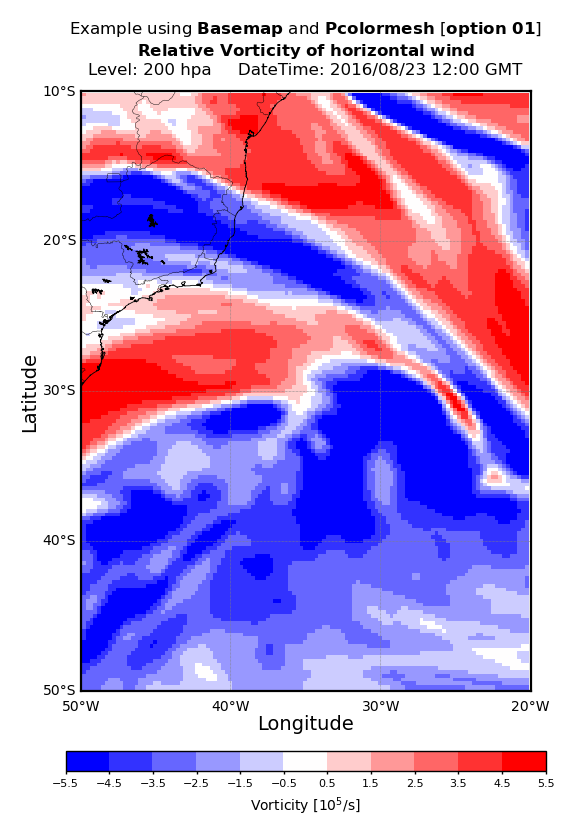

In [12]:
# PLOTTING VORTICITY OF HORIZONTAL WIND [OPTION 01: USING BASEMAP AND PCOLORMESH]

# calculate corners of pixels (only for pcolormesh)
lonsCor = np.concatenate((lons-(lons[1]-lons[0])/2.0,[lons[-1]+(lons[1]-lons[0])/2.0]))
latsCor = np.concatenate((lats+(lats[0]-lats[1])/2.0,[lats[-1]-(lats[0]-lats[1])/2.0]))

# creates 2D array of lons corners and lats corners
lonsCor2D, latsCor2D = np.meshgrid(lonsCor, latsCor)


# import Basemap
from mpl_toolkits.basemap import Basemap

# define plot area
bmap = Basemap(projection='cyl', llcrnrlat=LatMin, urcrnrlat=LatMaj,
               llcrnrlon=LonMin, urcrnrlon=LonMaj, resolution='i')

# creates figure
fig = plt.figure('Vorticity Basemap Pcolormesh',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75])

# add limits
bmap.drawcoastlines(linewidth=0.3, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.3, linestyle='solid', color='black')
bmap.drawstates(linewidth=0.15, linestyle='solid', color='black')

# add parallels and meridians
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0),labels = [True,False,False,True],
                   linewidth=0.25, color='grey',fontsize=5)
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0),labels = [True,False,False,True],
                   linewidth=0.25, color='grey',fontsize=5)

# plot image 
img = bmap.pcolormesh(lonsCor2D, latsCor2D, vor, cmap=mypalette, norm=norm)

# customizing the plot border
plt.rcParams['axes.linewidth'] = 0.3

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=8.5)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=15.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Basemap}$ and $\bf{Pcolormesh}$ [$\bf{option}$ $\bf{01}$]',
                     r'$\bf{Relative}$ $\bf{Vorticity}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     LevPres,
                     DateTime.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

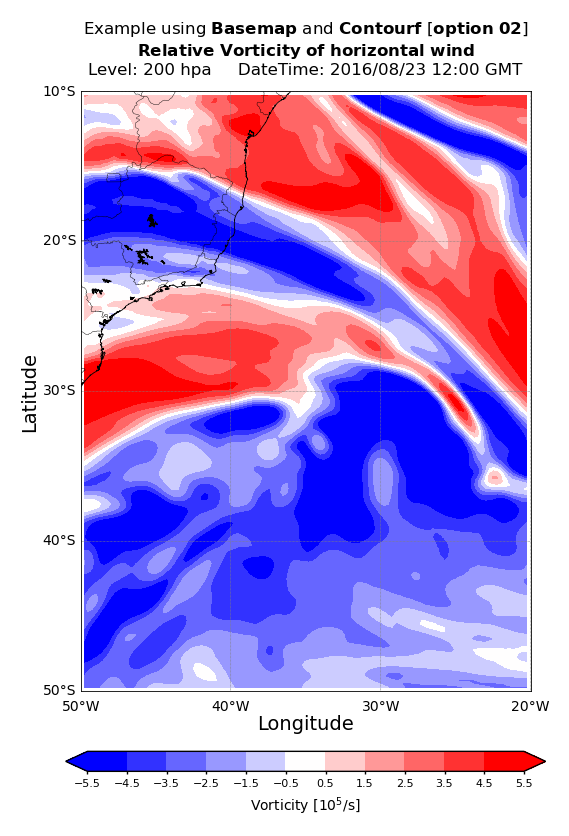

In [13]:
# PLOTTING VORTICITY OF HORIZONTAL WIND [OPTION 02: USING BASEMAP AND CONTOURF]

# import Basemap
from mpl_toolkits.basemap import Basemap

# define plot area
bmap = Basemap(projection='cyl', llcrnrlat=LatMin, urcrnrlat=LatMaj,
               llcrnrlon=LonMin, urcrnrlon=LonMaj, resolution='i')

# creates figure
fig = plt.figure('Vorticity Basemap Contourf',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75])

# add limits
bmap.drawcoastlines(linewidth=0.3, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.3, linestyle='solid', color='black')
bmap.drawstates(linewidth=0.15, linestyle='solid', color='black')

# add parallels and meridians
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0),labels = [True,False,False,True],
                   linewidth=0.25, color='grey',fontsize=5)
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0),labels = [True,False,False,True],
                   linewidth=0.25, color='grey',fontsize=5)

# plot image
img = bmap.contourf(lonsCen2D, latsCen2D, vor, cmap=mypalette,
                    levels=tickslabels, extend='both')

# customizing the plot border
plt.rcParams['axes.linewidth'] = 0.3

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=8.5)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=15.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Basemap}$ and $\bf{Contourf}$ [$\bf{option}$ $\bf{02}$]',
                     r'$\bf{Relative}$ $\bf{Vorticity}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     LevPres,
                     DateTime.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

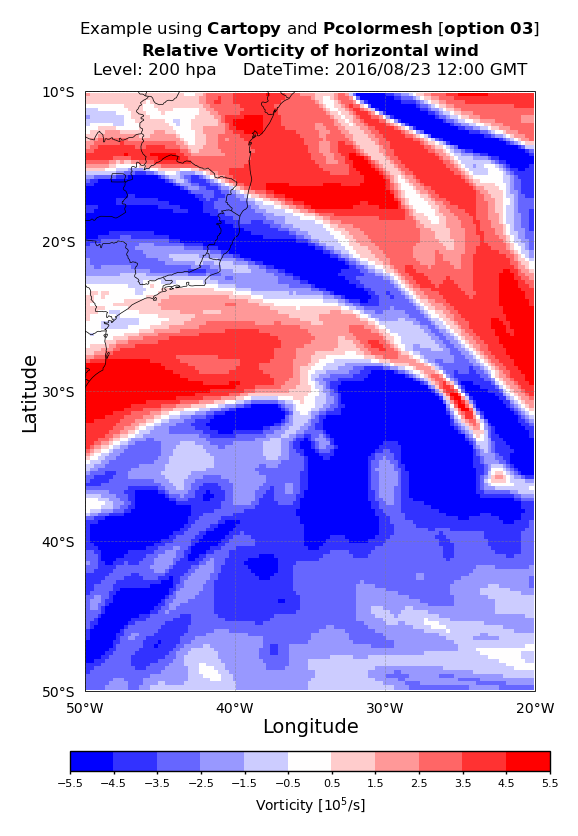

In [15]:
# PLOTTING VORTICITY OF HORIZONTAL WIND [OPTION 03: USING CARTOPY AND PCOLORMESH]

# calculate corners of pixels (only for pcolormesh)
lonsCor = np.concatenate((lons-(lons[1]-lons[0])/2.0,[lons[-1]+(lons[1]-lons[0])/2.0]))
latsCor = np.concatenate((lats+(lats[0]-lats[1])/2.0,[lats[-1]-(lats[0]-lats[1])/2.0]))

# creates 2D array of lons corners and lats corners
lonsCor2D, latsCor2D = np.meshgrid(lonsCor, latsCor)


# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Vorticity Cartopy Pcolormesh', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)
ax.set_extent(extents=[LonMin-360.0, LonMaj-360.0, LatMin, LatMaj],
              crs=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = ax.pcolormesh(lonsCor2D-360.0, latsCor2D, vor,
                    cmap=mypalette, norm=norm, transform=FieldProj)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(LonMin, LonMaj+10.0, 10.0) -360.0
ax.set_xticks(xticks)#, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)


# sets Y axis characteristics
yticks = np.arange(LatMaj, LatMin-10.0, -10.0)
ax.set_yticks(yticks)#, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_xlim(LonMin-360.0, LonMaj-360.0)
ax.set_ylim(LatMin, LatMaj)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Cartopy}$ and $\bf{Pcolormesh}$ [$\bf{option}$ $\bf{03}$]',
                     r'$\bf{Relative}$ $\bf{Vorticity}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     LevPres,
                     DateTime.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

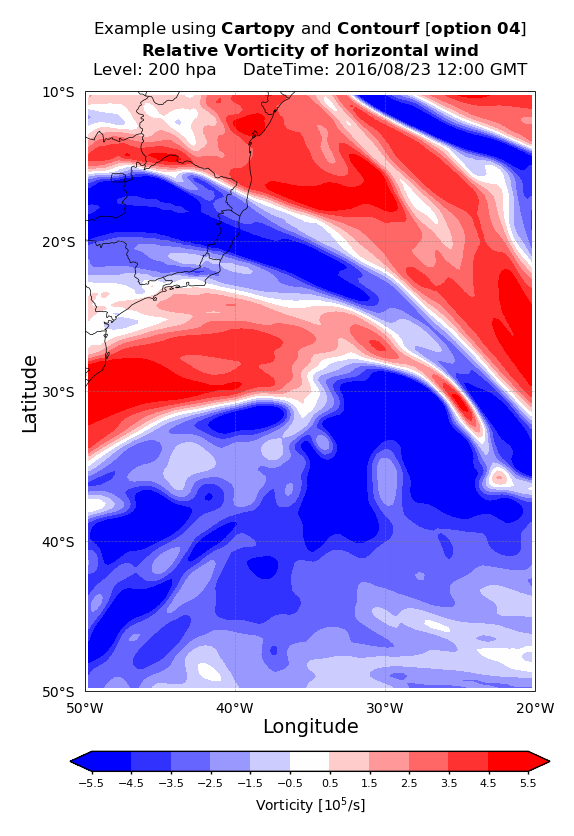

In [16]:
# PLOTTING VORTICITY OF HORIZONTAL WIND [OPTION 04: USING CARTOPY AND CONTOURF]

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Vorticity Cartopy Contourf', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)
ax.set_extent(extents=[LonMin-360.0, LonMaj-360.0, LatMin, LatMaj],
              crs=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = ax.contourf(lonsCen2D-360.0, latsCen2D, vor,
                  cmap=mypalette, levels=tickslabels,
                  extend='both', transform=FieldProj)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(LonMin, LonMaj+10.0, 10.0) -360.0
ax.set_xticks(xticks)#, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)


# sets Y axis characteristics
yticks = np.arange(LatMaj, LatMin-10.0, -10.0)
ax.set_yticks(yticks)#, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_xlim(LonMin-360.0, LonMaj-360.0)
ax.set_ylim(LatMin, LatMaj)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Cartopy}$ and $\bf{Contourf}$ [$\bf{option}$ $\bf{04}$]',
                     r'$\bf{Relative}$ $\bf{Vorticity}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     LevPres,
                     DateTime.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

In [17]:
# creates a custom color palette with
# custom_color_palette package (https://github.com/joaohenry23/custom_color_palette)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import custom_color_palette as ccpl

mypalette, colorslabels = ccpl.creates_palette([plt.cm.RdBu_r],[-5.5,5.5],EditPalette=[[-6.5,6.5,-5.5,5.5]])
norm = colors.BoundaryNorm(colorslabels, ncolors=mypalette.N)

# creating colorbar labels
tickslabels = np.arange(-5.5, 6.5, 1.0)

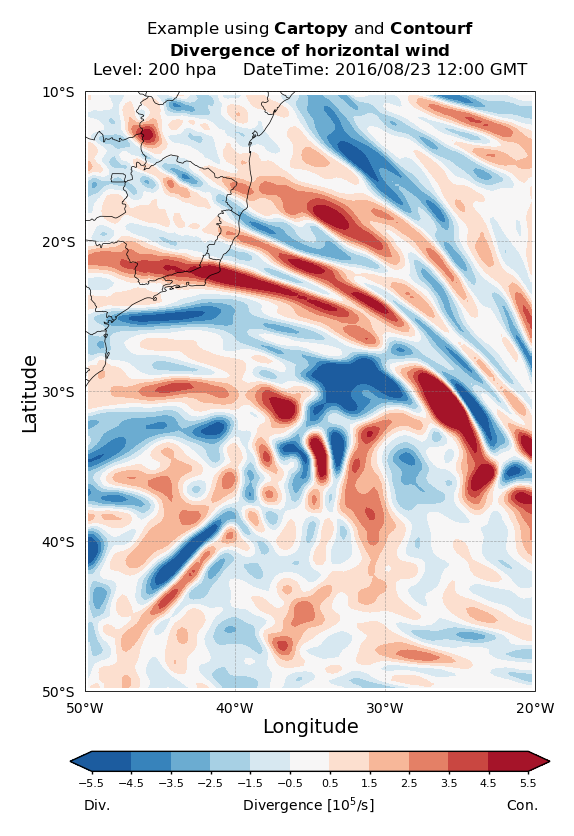

In [18]:
# PLOTTING DIVERGENCE OF HORIZONTAL WIND USING CARTOPY AND CONTOURF

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Divergence Cartopy Contourf', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)
ax.set_extent(extents=[LonMin-360.0, LonMaj-360.0, LatMin, LatMaj],
              crs=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = ax.contourf(lonsCen2D-360.0, latsCen2D, div,
                  cmap=mypalette, levels=tickslabels,
                  extend='both', transform=FieldProj)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label('Div.'+' '*30+r'Divergence [$10^{5}$/s]'+' '*30+'Con.', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(LonMin, LonMaj+10.0, 10.0) -360.0
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)


# sets Y axis characteristics
yticks = np.arange(LatMaj, LatMin-10.0, -10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_xlim(LonMin-360.0, LonMaj-360.0)
ax.set_ylim(LatMin, LatMaj)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Cartopy}$ and $\bf{Contourf}$',
                     r'$\bf{Divergence}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     LevPres,
                     DateTime.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

In [19]:
# creates a custom color palette with
# custom_color_palette package (https://github.com/joaohenry23/custom_color_palette)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import custom_color_palette as ccpl

mypalette, colorslabels = ccpl.creates_palette([plt.cm.coolwarm],[-5.5,5.5])
norm = colors.BoundaryNorm(colorslabels, ncolors=mypalette.N)

# creating colorbar labels
tickslabels = np.arange(-5.5, 6.5, 1.0)

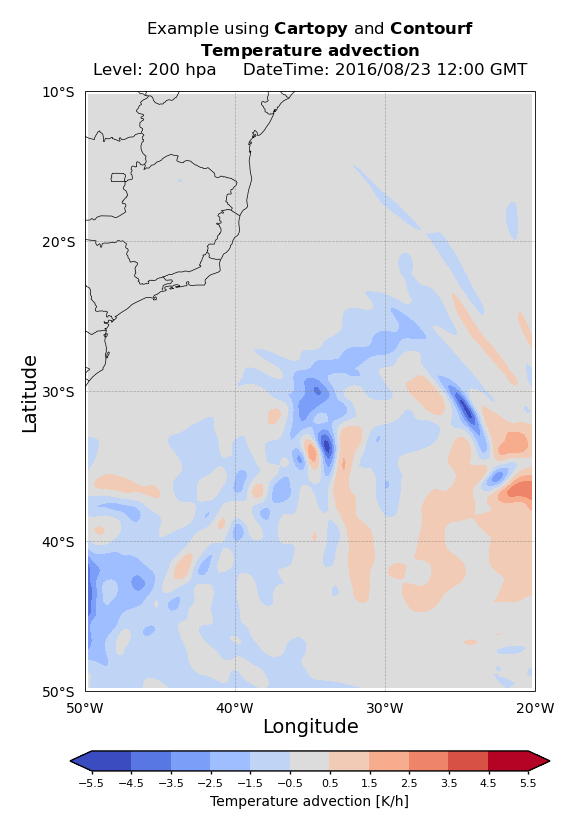

In [20]:
# PLOTTING TEMPERATURE ADVECTION USING CARTOPY AND CONTOURF

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Temperature advection Cartopy Contourf', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)
ax.set_extent(extents=[LonMin-360.0, LonMaj-360.0, LatMin, LatMaj],
              crs=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = ax.contourf(lonsCen2D-360.0, latsCen2D, temp_adv,
                  cmap=mypalette, levels=tickslabels,
                  extend='both', transform=FieldProj)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Temperature advection [K/h]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(LonMin, LonMaj+10.0, 10.0) -360.0
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)


# sets Y axis characteristics
yticks = np.arange(LatMaj, LatMin-10.0, -10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_xlim(LonMin-360.0, LonMaj-360.0)
ax.set_ylim(LatMin, LatMaj)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Cartopy}$ and $\bf{Contourf}$',
                     r'$\bf{Temperature}$ $\bf{advection}$',
                     LevPres,
                     DateTime.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()